* **Name**: Mazlum Davut CELIK
* **Scheduled project review date/time**: 7 Jan 2024
* **Linkedin profile URL**: https://www.linkedin.com/in/mazlumdavutcelik/
* **Medium profile URL** : https://medium.com/@mazlumdavutcelik

############################################################################################
# Introduction
############################################################################################

Hello, welcome to my note book of [house price](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/code).
I hope it will be an explanatory and understandable project for you. You can share your questions, suggestions or thoughts about this project  with me in comments.

## About Dataset
############################################################################################

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.


The dataset has been provided and can be found in the kc_house_data.csv file in this repository.

The column names and descriptions as provided can be found in the column_names.md file in this repository. For convenience they have been reproduced below.

Column Names and descriptions for Kings County Data Set

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** - is prediction target
* **bedroomsNumber** - of Bedrooms/House
* **bathroomsNumber** - of bathrooms/bedrooms
* **sqft_livingsquare** - footage of the home
* **sqft_lotsquare** - footage of the lot
* **floorsTotal** - floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


We will adopt a data science workflow that includes:

* Acquisition (importing data)
* Explore (Explarotary Data Analysis & Feature Engineering)
* Scrub (clean data, deal with missing values and data types)
* Model (create our predictive model)
* Interpret (comment on our model and findings)


To increase readability, details are included for each problem during the discovery phase.

Feature engineering is performed wherever it is needed.

The principles can be applied to a data set of your choice.








In [120]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/housesalesprediction/kc_house_data.csv
/kaggle/input/washington-zipcode/usa_zipcode_of_wa-1564j.csv


Let's begin by importing the necessary libraries.

## Load data
############################################################################################

Let's read in our dataset using Pandas and create a DataFrame.

In [121]:
df = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')

#This data set is explained under the title 'zipcode'
wa_zipcod = pd.read_csv('/kaggle/input/washington-zipcode/usa_zipcode_of_wa-1564j.csv')

First, let's take an overview of the data, the size of the data, variable types, some descriptive statistical information for numerical variables.

In [122]:
#View to Data
############################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile(q=[0, 0.05, 0.50, 0.95, 0.99, 1], numeric_only=bool).T)


In [123]:
# Apply function to df
check_df(df)

##################### Shape #####################
(21613, 21)
##################### Types #####################
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
##################### Head #####################
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00     

"date" should be changed to a DateTime object, to make it easier to manipulate and extract month of sale

"sqft_basement" should be of type float

When the Quantiles information is examined, it is easily seen that there are outliers and some variables have an unbalanced structure. In the following steps, the variables will be evaluated one by one.

Now let's determine the numerical and categorical variables and examine these variables.

First, let's examine the existing variables without doing anything. But we need to make a small change. Here, 'date', 'id' and 'zipcode' variables should not be evaluated as numeric values.

############################################################################################
# Exploratory Data Analysis & Feature Engineering
############################################################################################

## 'id' Variable
############################################################################################

There are repeating 'id' values in the data set. This means: There are houses that were sold more than once during the period when the data set was created.
First of all, if you have recurring values, we wanted to delete the old discounts except the most current one. But we gave up this idea. Because we want to obtain new variables using the 'date' variable. We think that the sales values of these sales, which are repeated on different dates, are more important.
I leave the code for those who want to delete other observations except the last sales value of houses sold twice.

In [124]:
'''

# Cheking for rows with same id
duplicates = df[df.duplicated(subset=['id'])]
print(len(duplicates))

# We note that there are multiple entries with same id. This would be due to the fact that a house may have been sold
# twice and thus have two entries.

df_sorted = df.sort_values(by='date', ascending=False)
df = df_sorted.drop_duplicates(subset='id', keep='first')

'''

"\n\n# Cheking for rows with same id\nduplicates = df[df.duplicated(subset=['id'])]\nprint(len(duplicates))\n\n# We note that there are multiple entries with same id. This would be due to the fact that a house may have been sold\n# twice and thus have two entries.\n\ndf_sorted = df.sort_values(by='date', ascending=False)\ndf = df_sorted.drop_duplicates(subset='id', keep='first')\n\n"

The 'id' variable is removed from the data set because it does not have any meaning for analysis.

## 'date' Variable
############################################################################################

In [125]:
#Changes date to DateTime object
df['date'] = pd.to_datetime(df['date'])

Note: I add "NEW_" in front of the names of newly created variables. Being able to notice newly created variables while examining the effects of all variables.

In [126]:
#Creating a new variable based on the date variable
def create_date_features(df, date_column):
    df['NEW_month'] = df[date_column].dt.month
    df['NEW_day_of_month'] = df[date_column].dt.day
    df['NEW_week_of_year'] = df[date_column].dt.isocalendar()['week']
    df['NEW_day_of_week'] = df[date_column].dt.dayofweek
    df['NEW_year'] = df[date_column].dt.year
    df["NEW_is_wknd"] = df[date_column].dt.weekday // 4
    df['NEW_is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['NEW_is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['NEW_quarter'] = df[date_column].dt.quarter
    df['NEW_is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['NEW_is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['NEW_is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df


In [127]:
# Apply function to df
df = create_date_features(df,"date")

In [128]:
# Seasonality Features
# 0: Winter , 1: Spring , 2: Summer , 3: Fall
df["NEW_season"] = np.where(df.NEW_month.isin([12, 1, 2]), 0, 1)
df["NEW_season"] = np.where(df.NEW_month.isin([3, 4, 5]), 1, df["NEW_season"])
df["NEW_season"] = np.where(df.NEW_month.isin([6, 7, 8]), 2, df["NEW_season"])
df["NEW_season"] = pd.Series(np.where(df.NEW_month.isin([9, 10, 11]), 3, df["NEW_season"])).astype("O")


In [129]:
# parts of month
# 0: beginning : begining of the month (1 to 10 th day)
# 1: mid : mind of the month ( 11 to 20 th day)
# 2: end : end of the month (21 to 31 th day )
df['NEW_parts_of_month'] = np.where(df.NEW_day_of_month.isin([1,2,3,4,5,6,7,8,9,10]), 0, 1)
df['NEW_parts_of_month'] = np.where(df.NEW_day_of_month.isin([11,12,13,14,15,16,17,18,19,20]), 1, df['NEW_parts_of_month'])
df['NEW_parts_of_month'] = np.where(df.NEW_day_of_month.isin([21,22,23,24,25,26,27,28,29,30,31]), 2, df['NEW_parts_of_month'])


## 'bedrooms' Variable
############################################################################################

          bedrooms      Ratio
bedrooms                     
3             9824  45.454125
4             6882  31.841947
2             2760  12.770092
5             1601   7.407579
6              272   1.258502
1              199   0.920742
7               38   0.175820
0               13   0.060149
8               13   0.060149
9                6   0.027761
10               3   0.013881
11               1   0.004627
33               1   0.004627
-----------------------------------------------------------------


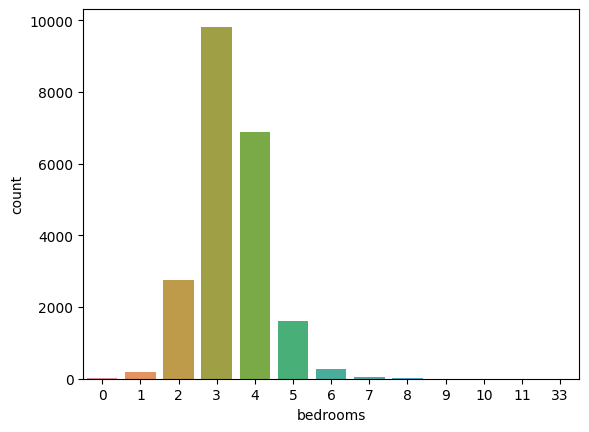

In [130]:
print(pd.DataFrame({'bedrooms': df['bedrooms'].value_counts(),
                    "Ratio": 100 * df['bedrooms'].value_counts() / len(df)}))


print("-----------------------------------------------------------------")


sns.countplot(x=df['bedrooms'], data=df)
plt.show()

When we examine the 'bedroom' variable, a house with 33 rooms stands out. The house with 33 bedrooms is worth exploring further.

In [131]:
df[df['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,NEW_year,NEW_is_wknd,NEW_is_month_start,NEW_is_month_end,NEW_quarter,NEW_is_quarter_start,NEW_is_quarter_end,NEW_is_year_end,NEW_season,NEW_parts_of_month
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,...,2014,0,0,0,2,0,0,0,2,2


With 1.75 bathrooms, a sale price of $640,000 it is likely that this house has 3 bedrooms and the 33 was a data entry error.

When this observation is examined in detail, it can be easily seen that the relevant observation cannot have 33 bedrooms. I think this value is a typo and should actually be 3. and I update this value to 3

In [132]:
# Fix typo for bedrooms
df.loc[15870, 'bedrooms'] = 3

In [133]:
df[df['bedrooms'] == 0].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,NEW_year,NEW_is_wknd,NEW_is_month_start,NEW_is_month_end,NEW_quarter,NEW_is_quarter_start,NEW_is_quarter_end,NEW_is_year_end,NEW_season,NEW_parts_of_month
875,6306400140,2014-06-12,1095000.0,0,0.0,3064,4764,3.5,0,2,...,2014,0,0,0,2,0,0,0,2,1
3119,3918400017,2015-02-05,380000.0,0,0.0,1470,979,3.0,0,2,...,2015,0,0,0,1,0,0,0,0,0
3467,1453602309,2014-08-05,288000.0,0,1.5,1430,1650,3.0,0,0,...,2014,0,0,0,3,0,0,0,2,0
4868,6896300380,2014-10-02,228000.0,0,1.0,390,5900,1.0,0,0,...,2014,0,0,0,4,0,0,0,3,0
6994,2954400190,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,...,2014,0,0,0,2,0,0,0,2,2


There is no house with 0 bedrooms. These values should actually be different values.

I am updating the values 0 for now so that it can be filled with more appropriate values later.

In [134]:
df['bedrooms'] = df['bedrooms'].replace(0, np.nan)
#We will fill this with the knn algorithm in the following sections.


## 'bedrooms' & 'price'
############################################################################################

In [135]:
pd.DataFrame({"TARGET_MEDIAN": df.groupby('bedrooms')['price'].median()})

,TARGET_MEDIAN
bedrooms,
1.0,299000.0
2.0,374000.0
3.0,413000.0
4.0,549997.5
5.0,620000.0
6.0,650000.0
7.0,728580.0
8.0,700000.0
9.0,817000.0


## 'bathrooms' variable
############################################################################################

           bathrooms      Ratio
bathrooms                      
2.50            5380  24.892426
1.00            3852  17.822607
1.75            3048  14.102623
2.25            2047   9.471152
2.00            1930   8.929811
1.50            1446   6.690418
2.75            1185   5.482811
3.00             753   3.484014
3.50             731   3.382224
3.25             589   2.725212
3.75             155   0.717161
4.00             136   0.629251
4.50             100   0.462684
4.25              79   0.365521
0.75              72   0.333133
4.75              23   0.106417
5.00              21   0.097164
5.25              13   0.060149
0.00              10   0.046268
5.50              10   0.046268
1.25               9   0.041642
6.00               6   0.027761
0.50               4   0.018507
5.75               4   0.018507
6.75               2   0.009254
8.00               2   0.009254
6.25               2   0.009254
6.50               2   0.009254
7.50               1   0.004627
7.75    

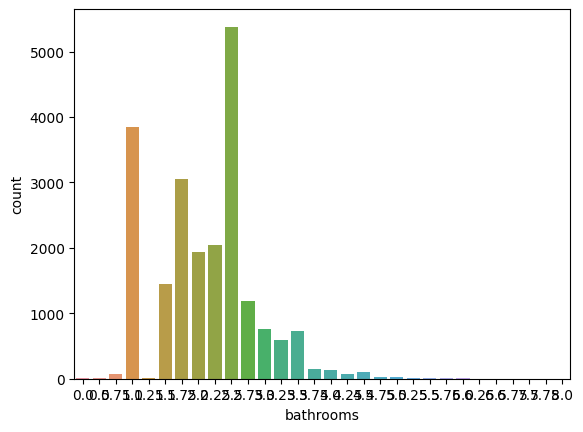

In [136]:
print(pd.DataFrame({'bathrooms': df['bathrooms'].value_counts(),
                    "Ratio": 100 * df['bathrooms'].value_counts() / len(df)}))


print("-----------------------------------------------------------------")


sns.countplot(x=df['bathrooms'], data=df)
plt.show()

In the United States, bathrooms are generally categorized as master bathroom, containing a varied shower and a tub that is adjoining to a master bedroom, a "full bathroom" (or "full bath"), containing four plumbing fixtures: bathtub/shower, or (separate shower), toilet, and sink; "half (1/2) bath" (or "powder room") containing just a toilet and sink; and "3/4 bath" containing toilet, sink, and shower, although the terms vary from market to market. In some U.S. markets, a toilet, sink, and shower are considered a "full bath". (wikipedia)

There is no house with 0 bathrooms. These values should actually be different values.

I am updating the values 0 for now so that it can be filled with more appropriate values later.

In [137]:
df['bathrooms'] = df['bathrooms'].replace(0, np.nan)


## 'bathrooms' & 'price'
############################################################################################

The sales price of the house with 7.5 bathrooms seems remarkable. When examined in detail, it was removed from 
the data set because it was a single observation and considering the other features of the house, the sales price 
was too low and would have a negative impact on the models to be created.

In [138]:
pd.DataFrame({"TARGET_MEDIAN": df.groupby('bathrooms')['price'].median()})

,TARGET_MEDIAN
bathrooms,
0.50,264000.0
0.75,273500.0
1.00,320000.0
1.25,516500.0
1.50,370000.0
1.75,422900.0
2.00,423250.0
2.25,472500.0
2.50,499950.0


The sales price of the house with 7.5 bathrooms seems remarkable. When examined in detail, it was removed from 
the data set because it was a single observation and considering the other features of the house, the sales price 
was too low and would have a negative impact on the models to be created.

In [139]:
df[df['bathrooms'] == 7.5]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,NEW_year,NEW_is_wknd,NEW_is_month_start,NEW_is_month_end,NEW_quarter,NEW_is_quarter_start,NEW_is_quarter_end,NEW_is_year_end,NEW_season,NEW_parts_of_month
8546,424049043,2014-08-11,450000.0,9.0,7.5,4050,6504,2.0,0,0,...,2014,0,0,0,3,0,0,0,2,1


In [140]:
# drop to df['bathrooms'] == 7.5
df.drop(8546,inplace=True)

## 'view' Variable
############################################################################################

       view      Ratio
view                  
0     19488  90.172127
2       963   4.455858
3       510   2.359800
1       332   1.536184
4       319   1.476032
-----------------------------------------------------------------


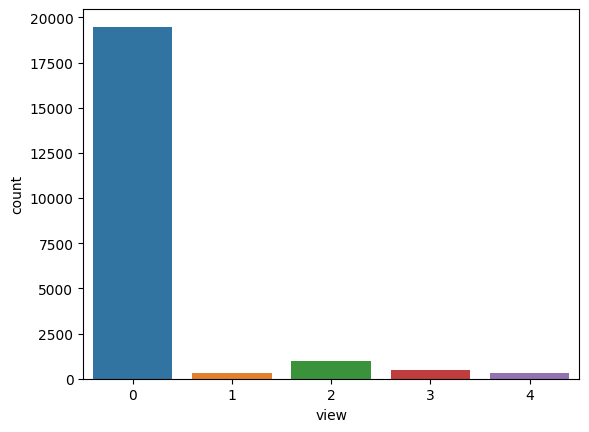

In [141]:
print(pd.DataFrame({'view': df['view'].value_counts(),
                    "Ratio": 100 * df['view'].value_counts() / len(df)}))

print("-----------------------------------------------------------------")

sns.countplot(x=df['view'], data=df)
plt.show()

We saw that view had mostly 0 values, indicating not been viewed, let us create a new feature viewed which has value 1 if the house has been viewed and 0 otherwise. We will drop the original view variable.

In [142]:
df['NEW_viewed'] = df['view'].map(lambda x: 1 if x > 0 else 0)
df['NEW_viewed'].head()

0    0
1    0
2    0
3    0
4    0
Name: NEW_viewed, dtype: int64

## 'yr_built' Variable
############################################################################################

count    21612.000000
mean      1971.003979
std         29.373598
min       1900.000000
0%        1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
100%      2015.000000
max       2015.000000
Name: yr_built, dtype: float64
------------------------------------------


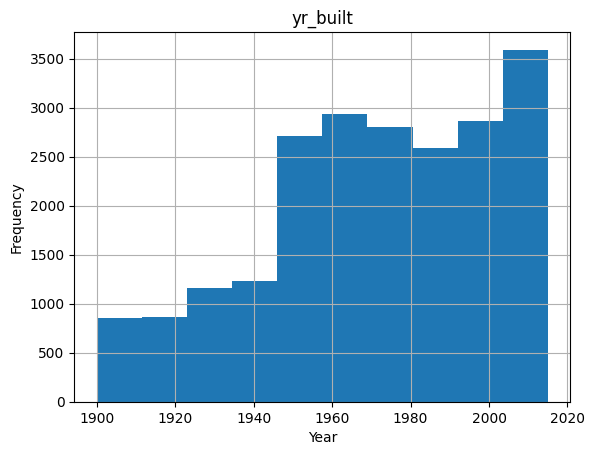

In [143]:
quantiles = [0, 0.25, 0.50, 0.75, 1]
print(df['yr_built'].describe(quantiles).T)
print('------------------------------------------')
df['yr_built'].hist()
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('yr_built')
plt.show()

We are going to define bins as the yr_built feature should be treated as a categorical variable. We will use the summary statistics (quartiles) to define our bins, so that we have roughly the same number of data points in each bin.


In [144]:
# Define bins based on statistics
yr_built_bins = [1899, 1950, 1975, 1997, 2016]
yr_built_labels = ['pre1950', '1950_to_1975', '1975_to_1997', '1997_to_2015']

# Map to bins using pd.cut()
df['NEW_yr_built'] = pd.cut(df['yr_built'], bins = yr_built_bins, labels = yr_built_labels).astype(object)

df['NEW_yr_built'].head()

0    1950_to_1975
1    1950_to_1975
2         pre1950
3    1950_to_1975
4    1975_to_1997
Name: NEW_yr_built, dtype: object

## 'yr_renovated' Variable
############################################################################################

count    21612.000000
mean        84.406163
std        401.688123
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%       2008.000000
max       2015.000000
Name: yr_renovated, dtype: float64
------------------------------------------


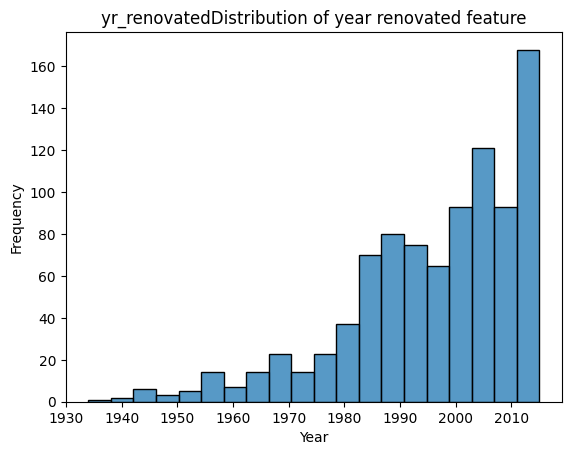

In [145]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['yr_renovated'].describe(quantiles).T)
print('------------------------------------------')
# Visualise yr_renovated post 1900 (to not show all the 0 values)
sns.histplot(x=df[df['yr_renovated'] > 1900]['yr_renovated'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("yr_renovatedDistribution of year renovated feature")
plt.show()

We will choose to only consider renovations which took place from 1985 onwards, on the basis that earlier renovations are likely to be obsolete. Let us create a new feature 'NEW_renovated_after85' which has value 1 if the house was renovated post 1985 and 0 otherwise.

In [146]:
# Define function to create renovated_after85 feature
df['NEW_renovated_after85'] = df['yr_renovated'].map(lambda x: 1 if x > 1985 else 0)
df['NEW_renovated_after85'].head()

0    0
1    1
2    0
3    0
4    0
Name: NEW_renovated_after85, dtype: int64

After the renovation, all buildings look like new. and this affects the building sales and price. I created a new variable as apparent building age. In other words, the year of renovation will be subtracted from the year of sale of the building, and if the building has not been renovated before, the year of construction of the building will be used. So how many years ago was the building last processed? The answer to the question will be clear

In [147]:

df['NEW_builted'] = df['NEW_year'] - df['yr_renovated'].replace({0: None}).fillna(df['yr_built'])

df['NEW_builted'].head()

0    59
1    23
2    82
3    49
4    28
Name: NEW_builted, dtype: int64

df[df['NEW_builted'] < 0].head()

We think that some observations indicate that the year of construction or renovation is before the year of sale, and that these values are incorrect.

In [148]:
df.drop(df[df['NEW_builted'] < 0].index,inplace=True)

## 'sqft_basement' variable
############################################################################################

count    21594.000000
mean       291.314022
std        442.298167
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%        430.000000
80%        700.000000
90%        970.000000
95%       1190.000000
99%       1660.000000
max       4820.000000
Name: sqft_basement, dtype: float64
------------------------------------------


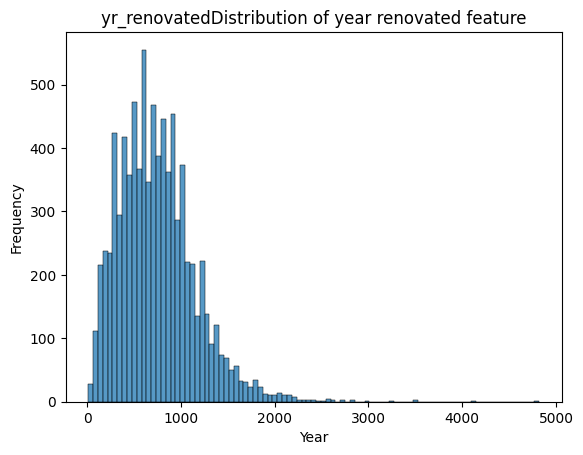

In [149]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['sqft_basement'].describe(quantiles).T)
print('------------------------------------------')
sns.histplot(x=df[df['sqft_basement'] > 0]['sqft_basement'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("yr_renovatedDistribution of year renovated feature")
plt.show()

As we saw that sqft_basement had mostly 0 values, indicating no basement, let us create a new feature has_basement which has value 1 if the house has a basement and 0 otherwise. We will then drop the original sqft_basement variable.


In [150]:
# Define function has_basement
df['NEW_has_basement'] = df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)

## Zipcode Variable
############################################################################################

'zipcode' has so many unique values that it is difficult to make a meaningful interpretation. to get less unique value
will create Washington cities based on zip code.
I got the csv file for the zipcode information of the city of Washington from [here](https://www.downloadexcelfiles.com/sites/default/files/docs/usa_zipcode_of_wa-1564j.csv). 

If you cannot access the site by the time you read this article. I accessed this file by typing 'washington zipcode' into the search engine.

In [151]:
wa_zipcod.head()

,zip,Zipcode name,City,State,County Name
0,98520,"ABERDEEN, WA",ABERDEEN,WA,GRAYS HARBOR
1,98220,"ACME, WA",ACME,WA,WHATCOM
2,99101,"ADDY, WA",ADDY,WA,STEVENS
3,98522,"ADNA, WA",ADNA,WA,LEWIS
4,99001,"AIRWAY HEIGHTS, WA",AIRWAY HEIGHTS,WA,SPOKANE


In [152]:
wa_zipcod.columns = ['zipcode', 'Zipcode_name', 'NEW_Neighbourhood', 'State', 'County_Name']
wa_zipcod = wa_zipcod.dropna(subset=['zipcode'])
wa_zipcod = wa_zipcod.drop(wa_zipcod.index[-1])
wa_zipcod.head()

df['zipcode'] = df['zipcode'].astype('int64')
wa_zipcod['zipcode'] = wa_zipcod['zipcode'].astype('int64')


df = pd.merge(df, wa_zipcod[['NEW_Neighbourhood','zipcode']], on='zipcode')


                   NEW_Neighbourhood      Ratio
NEW_Neighbourhood                              
SEATTLE                         8960  41.493007
RENTON                          1597   7.395573
BELLEVUE                        1407   6.515699
KENT                            1203   5.570992
REDMOND                          979   4.533667
KIRKLAND                         977   4.524405
AUBURN                           912   4.223395
SAMMAMISH                        800   3.704733
FEDERAL WAY                      779   3.607484
ISSAQUAH                         733   3.394461
MAPLE VALLEY                     590   2.732240
WOODINVILLE                      470   2.176531
SNOQUALMIE                       310   1.435584
KENMORE                          283   1.310549
MERCER ISLAND                    281   1.301287
ENUMCLAW                         234   1.083634
NORTH BEND                       221   1.023432
BOTHELL                          195   0.903029
DUVALL                           190   0

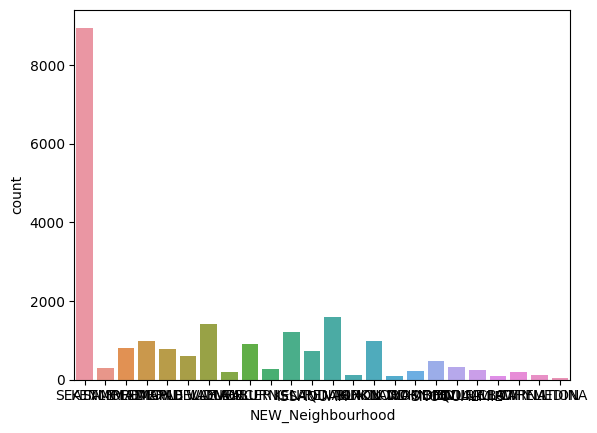

In [153]:
print(pd.DataFrame({'NEW_Neighbourhood': df['NEW_Neighbourhood'].value_counts(),
                    "Ratio": 100 * df['NEW_Neighbourhood'].value_counts() / len(df)}))

print("-----------------------------------------------------------------")

sns.countplot(x=df['NEW_Neighbourhood'], data=df)
plt.show()

## 'floors' Variable
############################################################################################

        floors      Ratio
floors                   
1.0      10677  49.444290
2.0       8231  38.117070
1.5       1908   8.835788
3.0        609   2.820228
2.5        161   0.745577
3.5          8   0.037047
-----------------------------------------------------------------


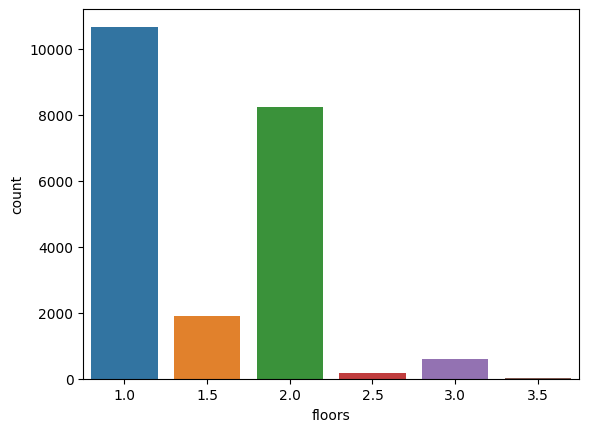

In [154]:
print(pd.DataFrame({'floors': df['floors'].value_counts(),
                    "Ratio": 100 * df['floors'].value_counts() / len(df)}))


print("-----------------------------------------------------------------")


sns.countplot(x=df['floors'], data=df)
plt.show()

Almost half of the data set consists of 1-storey buildings, followed by 2-storey buildings, and only these two features constitute 87% of the data set.
No change is required for this variable.

## 'condition' Variable
############################################################################################

           condition      Ratio
condition                      
3              14012  64.888395
4               5679  26.298972
5               1701   7.877188
2                172   0.796518
1                 30   0.138927
-----------------------------------------------------------------


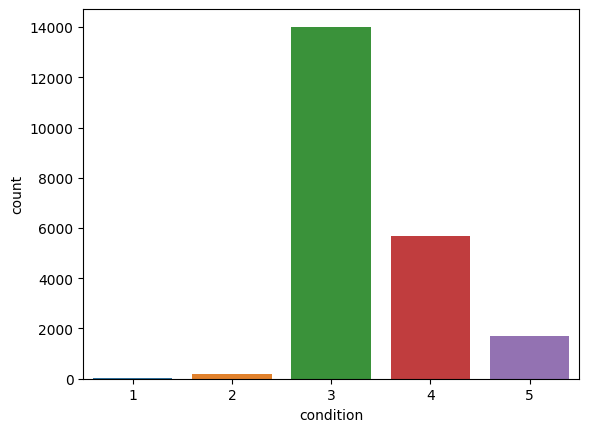

In [155]:
print(pd.DataFrame({'condition': df['condition'].value_counts(),
                    "Ratio": 100 * df['condition'].value_counts() / len(df)}))


print("-----------------------------------------------------------------")


sns.countplot(x=df['condition'], data=df)
plt.show()

## 'grade' variable
############################################################################################

       grade      Ratio
grade                  
7       8979  41.580995
8       6060  28.063351
9       2609  12.082060
6       2037   9.433176
10      1132   5.242197
11       399   1.847735
5        242   1.120682
12        90   0.416782
4         29   0.134297
13        13   0.060202
3          3   0.013893
1          1   0.004631
-----------------------------------------------------------------


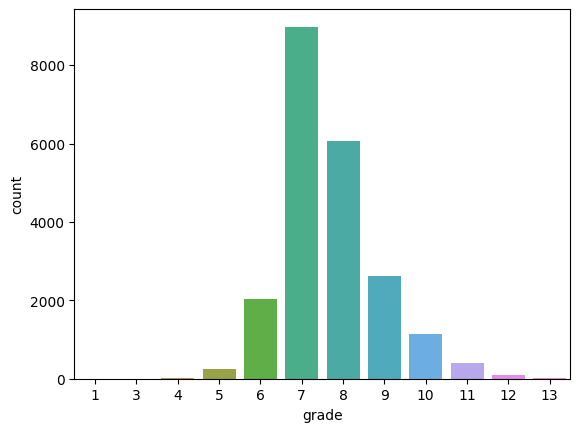

In [156]:
print(pd.DataFrame({'grade': df['grade'].value_counts(),
                    "Ratio": 100 * df['grade'].value_counts() / len(df)}))


print("-----------------------------------------------------------------")


sns.countplot(x=df['grade'], data=df)
plt.show()

## 'sqft_above' Variable
############################################################################################

count    21594.000000
mean      1788.123460
std        827.946026
min        290.000000
5%         850.000000
10%        970.000000
20%       1120.000000
30%       1260.000000
40%       1400.000000
50%       1560.000000
60%       1760.000000
70%       2040.000000
80%       2410.000000
90%       2950.000000
95%       3400.000000
99%       4370.700000
max       9410.000000
Name: sqft_above, dtype: float64
------------------------------------------


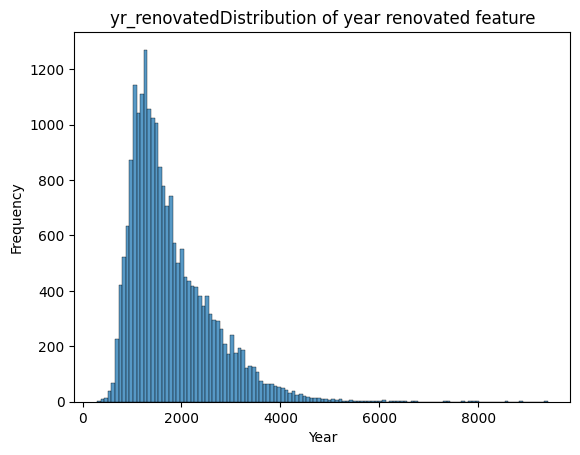

In [157]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['sqft_above'].describe(quantiles).T)
print('------------------------------------------')
sns.histplot(x=df['sqft_above'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("yr_renovatedDistribution of year renovated feature")
plt.show()

## 'sqft_living' variable
############################################################################################

count    21594.000000
mean      2079.437483
std        918.055541
min        290.000000
5%         940.000000
10%       1090.000000
20%       1320.000000
30%       1520.000000
40%       1710.000000
50%       1910.000000
60%       2130.000000
70%       2400.000000
80%       2730.000000
90%       3250.000000
95%       3760.000000
99%       4980.000000
max      13540.000000
Name: sqft_living, dtype: float64
---------------------------------------------


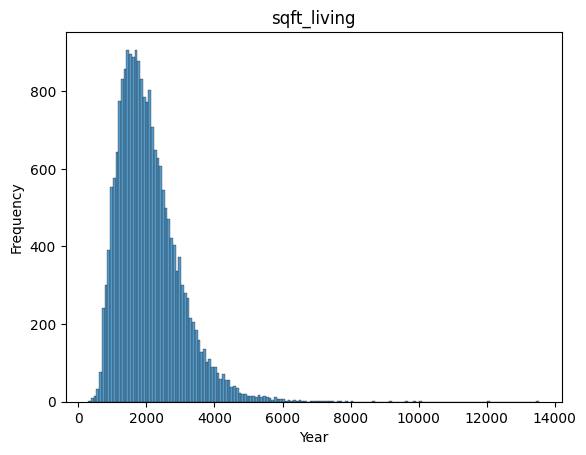

In [158]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['sqft_living'].describe(quantiles).T)
print('---------------------------------------------')
sns.histplot(x=df['sqft_living'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("sqft_living")
plt.show()

## 'sqft_lot' Variable
############################################################################################

count    2.159400e+04
mean     1.511378e+04
std      4.143732e+04
min      5.200000e+02
5%       1.804650e+03
10%      3.326600e+03
20%      4.649600e+03
30%      5.612000e+03
40%      6.750000e+03
50%      7.620000e+03
60%      8.522600e+03
70%      9.800000e+03
80%      1.219000e+04
90%      2.139970e+04
95%      4.335945e+04
99%      2.130080e+05
max      1.651359e+06
Name: sqft_lot, dtype: float64
---------------------------------------------


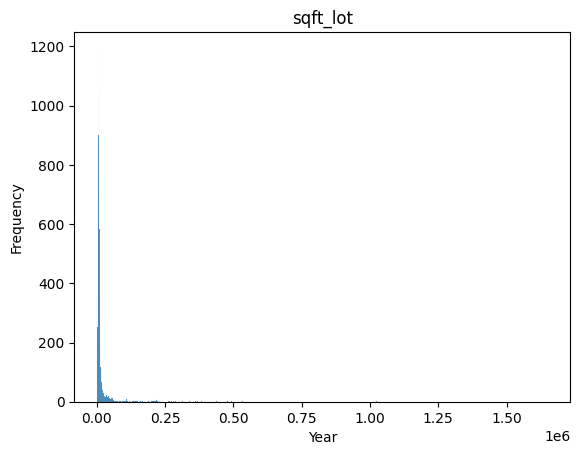

In [159]:

quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['sqft_lot'].describe(quantiles).T)
print('---------------------------------------------')
sns.histplot(x=df['sqft_lot'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("sqft_lot")
plt.show()

## 'sqft_living15' Variable
############################################################################################

count    21594.000000
mean      1986.595397
std        685.493839
min        399.000000
5%        1140.000000
10%       1250.000000
20%       1420.000000
30%       1550.000000
40%       1690.000000
50%       1840.000000
60%       2020.000000
70%       2230.000000
80%       2510.000000
90%       2930.000000
95%       3300.000000
99%       4080.000000
max       6210.000000
Name: sqft_living15, dtype: float64
---------------------------------------------


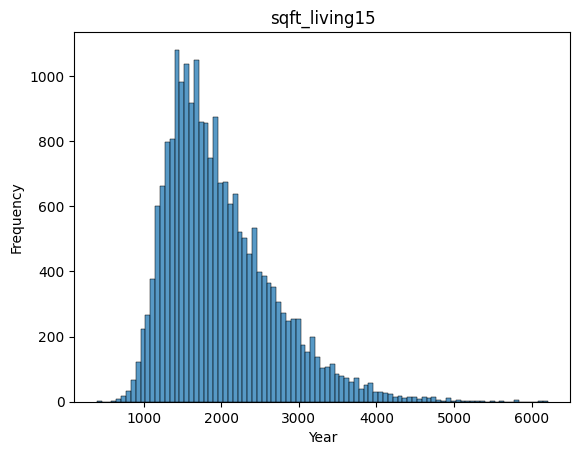

In [160]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['sqft_living15'].describe(quantiles).T)
print('---------------------------------------------')
sns.histplot(x=df['sqft_living15'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("sqft_living15")
plt.show()

## "sqft_lot15" Varable
############################################################################################

count     21594.000000
mean      12773.066546
std       27315.116976
min         651.000000
5%         2001.950000
10%        3675.000000
20%        4800.000000
30%        5627.000000
40%        6753.400000
50%        7620.000000
60%        8383.800000
70%        9529.000000
80%       11098.200000
90%       17842.800000
95%       37094.850000
99%      157778.490000
max      871200.000000
Name: sqft_lot15, dtype: float64
---------------------------------------------


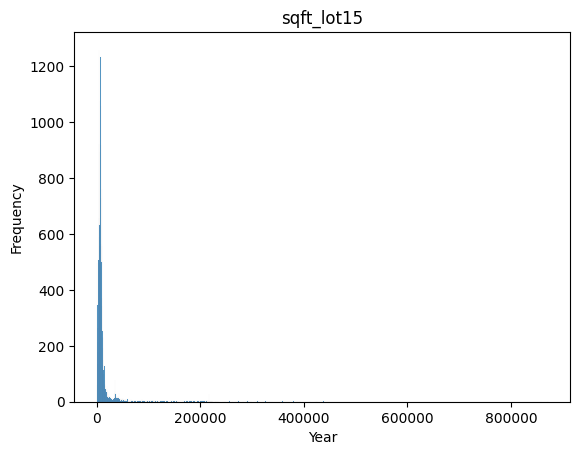

In [161]:
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
print(df['sqft_lot15'].describe(quantiles).T)
print('---------------------------------------------')
sns.histplot(x=df['sqft_lot15'], data=df)
plt.xlabel("Year")
plt.ylabel('Frequency')
plt.title("sqft_lot15")
plt.show()

## 'sqft_living' & 'sqft_living15' variables
############################################################################################

In [162]:

df['NEW_change_sqft_living'] = (df['sqft_living'] - df['sqft_living15']).map(lambda x: 'smaller' if x < 0 else ('same' if x == 0 else 'bigger'))

print(pd.DataFrame({'NEW_change_sqft_living': df['NEW_change_sqft_living'].value_counts(),
                    "Ratio": 100 * df['NEW_change_sqft_living'].value_counts() / len(df)}))


                        NEW_change_sqft_living      Ratio
NEW_change_sqft_living                                   
bigger                                    9830  45.521904
smaller                                   9201  42.609058
same                                      2563  11.869038


## 'sqft_lot' & 'sqft_lot15' variables
############################################################################################

In [163]:

df['NEW_change_sqft_lot'] = (df['sqft_lot'] - df['sqft_lot15']).map(lambda x: 'smaller' if x < 0 else ('same' if x == 0 else 'bigger'))

print(pd.DataFrame({'NEW_change_sqft_lot': df['NEW_change_sqft_lot'].value_counts(),
                    "Ratio": 100 * df['NEW_change_sqft_lot'].value_counts() / len(df)}))


                     NEW_change_sqft_lot      Ratio
NEW_change_sqft_lot                                
bigger                              8593  39.793461
smaller                             8532  39.510975
same                                4469  20.695564


### drop same of variables


In [164]:
df.drop('id', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('view', axis=1, inplace=True)
df.drop('yr_renovated', axis=1, inplace=True)
df.drop('sqft_basement', axis=1, inplace=True)
df.drop('zipcode', axis=1, inplace=True)
df.drop('yr_built', axis=1, inplace=True)

############################################################################################
# outliers
############################################################################################

In [165]:

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit



def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [166]:
outlier_check = [col for col in df.columns if  df[col].nunique() > 53]


for col in outlier_check:
    print(col, check_outlier(df,col))

price True
sqft_living True
sqft_lot True
sqft_above True
lat True
long True
sqft_living15 True
sqft_lot15 True
NEW_builted False


In [167]:
# Replace outlier
for col in outlier_check:
    replace_with_thresholds(df,col)

check outlier again

In [168]:
for col in outlier_check:
    print(col, check_outlier(df,col))

price False
sqft_living False
sqft_lot False
sqft_above False
lat False
long False
sqft_living15 False
sqft_lot15 False
NEW_builted False


############################################################################################
# Missing Values
############################################################################################

In [169]:
int_cols = list(df.select_dtypes(exclude='object').columns)


imputer = KNNImputer(n_neighbors=10)
df[int_cols] = imputer.fit_transform(df[int_cols])


############################################################################################
# Encoding
############################################################################################

### Label Encoding & Binary Encoding
############################################################################################


In [170]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [171]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

### One-Hot Encoding
############################################################################################

In [172]:
ohe_cols = [col for col in df.columns if 53 >= df[col].nunique() > 2]

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
df_encoded = pd.DataFrame(encoder.fit_transform(df[ohe_cols]), columns=encoder.get_feature_names_out(ohe_cols))

df = pd.concat([df, df_encoded], axis=1)
df.drop(ohe_cols, axis=1, inplace=True)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


############################################################################################
# RobustScaler
############################################################################################

In [173]:
numcol = [col for col in df.columns if df[col].nunique() > 53][1:]

scaler = RobustScaler()
df[numcol] = scaler.fit_transform(df[numcol])

In [174]:
df = df.reset_index(drop=True)

## Correlation Matrix

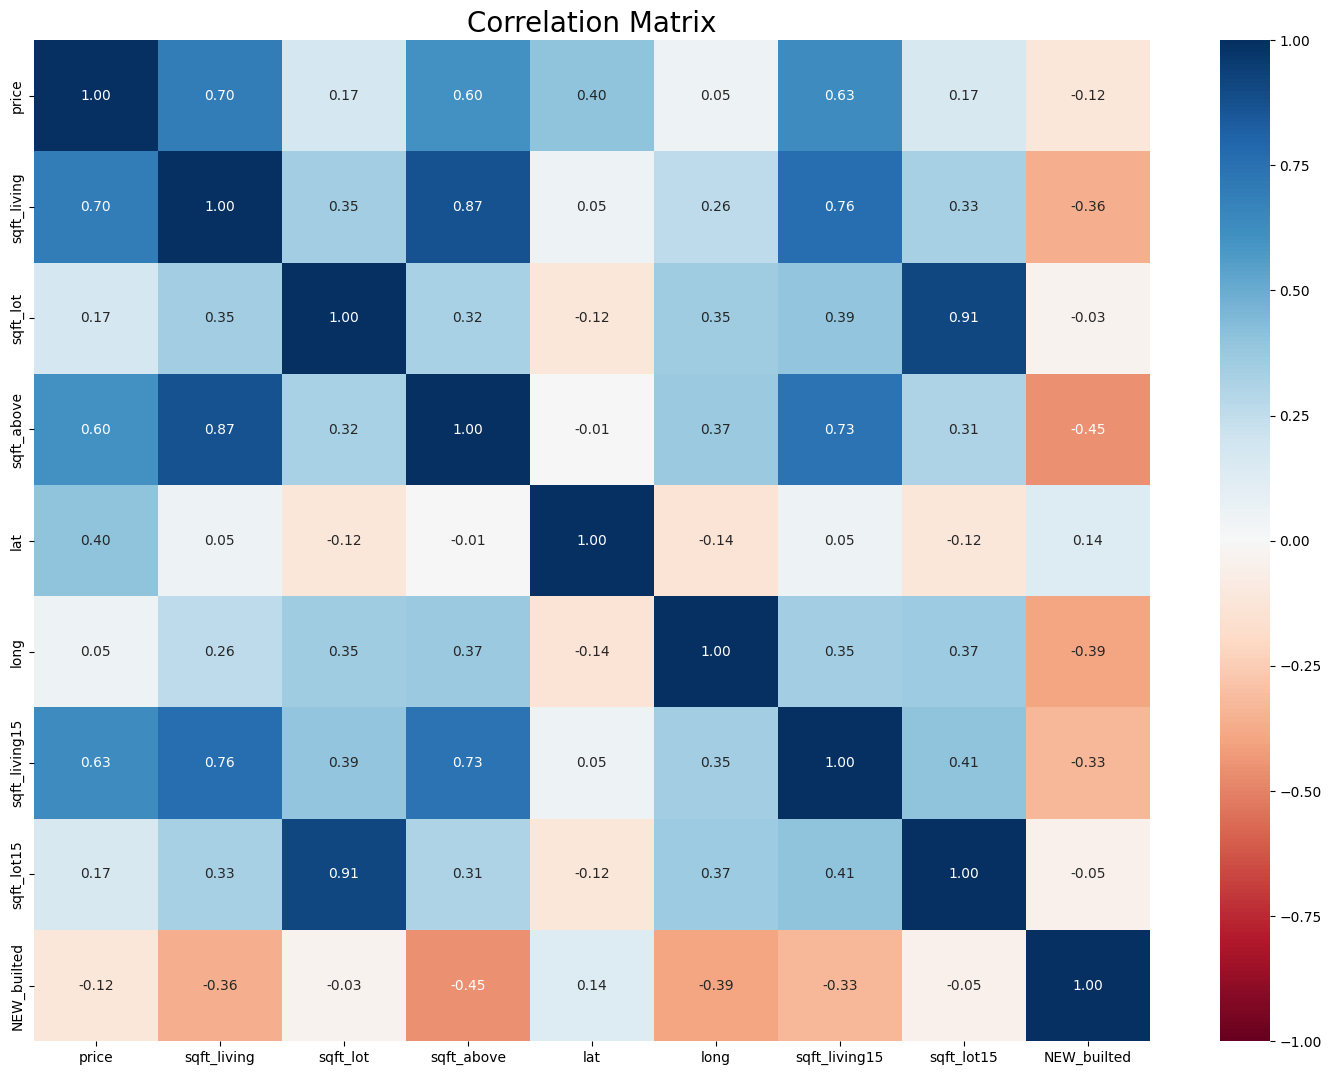

In [175]:
cor = [col for col in df.columns if  df[col].nunique() > 53]

df[cor].corr()['price']

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[cor].corr(), annot=True, fmt=".2f", ax=ax, cmap="RdBu", vmin=-1)
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

############################################################################################
# Train- Test
############################################################################################

In [176]:
X = df.drop('price', axis=1)
y = df[["price"]]




X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=1)


############################################################################################
# Base Models
############################################################################################

### Models and hyperparameter
############################################################################################

In [177]:

models = [('LR', LinearRegression(n_jobs=-1), {}),
          ("Ridge", Ridge(), {'alpha': [0.1, 1, 10]}),
          ("Lasso", Lasso(), {'alpha': [0.1, 1, 10]}),
          ("ElasticNet", ElasticNet(), {'max_iter': [1000,5000],
                                        'alpha': [0.1, 1, 10],
                                        'l1_ratio': [0.1, 0.5, 0.9]}),
          ('KNN', KNeighborsRegressor(n_jobs=-1), {'n_neighbors': [3, 5, 7]}),
          ('CART', DecisionTreeRegressor(), {'max_depth': [None, 10, 20]}),
          ('RF', RandomForestRegressor(n_jobs=-1), {"max_depth": [5, 8, 15, None],
                                           "max_features": [5, 7, "auto"],
                                           "min_samples_split": [8, 15, 20],
                                           "n_estimators": [200, 500, 1000]}),

          ('GBM', GradientBoostingRegressor(), {'n_estimators': [100, 200, 300],
                                                'max_depth': [3, 5, 7],
                                                'learning_rate': [0.01, 0.1, 0.2]}),
          ("XGBoost", XGBRegressor(objective='reg:squarederror', n_jobs=-1), {'n_estimators': [100, 200, 300],
                                                                   'max_depth': [3, 5, 7],
                                                                   'learning_rate': [0.01, 0.1, 0.2],
                                                                   "colsample_bytree": [0.5, 0.7, 1]}),
          ("LightGBM", LGBMRegressor(n_jobs=-1), {'n_estimators': [100, 200, 300],
                                         'max_depth': [3, 5, 7],
                                         'learning_rate': [0.01, 0.1, 0.2],
                                         "colsample_bytree": [0.5, 0.7, 1]}),
          ("CatBoost", CatBoostRegressor(verbose=False, thread_count=-1), {'n_estimators': [100, 200, 300],
                                                          'max_depth': [3, 5, 7],
                                                          'learning_rate': [0.01, 0.1, 0.2]})
          ]


In [ ]:
scores = []


for model_name, model, param_grid in models:
    print(model_name)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Best Params
    best_params = grid_search.best_params_

    # Best model
    best_model = model.set_params(**best_params)

    # Model training
    best_model.fit(X_train, y_train)

    # pred
    y_pred = best_model.predict(X_test)

    # RMSE 
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(rmse)

    # add to list
    scores.append({
        'model': model_name,
        'best_params': best_params,
        'best_model': best_model,
        'rmse': rmse
    })


LR
246971815879125.34
Ridge
108121.54684043695
Lasso


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.870e+13, tolerance: 7.183e+10
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.076e+13, tolerance: 7.220e+10
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.549e+13, tolerance: 7.239e

108004.24909059406
ElasticNet
111655.50700030666
KNN
139589.83039537095
CART
101462.01505599002
RF


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

############################################################################################
# RESULTS
############################################################################################

In [ ]:
# results
for score in scores:
    print(f"{score['model']} - Best Parametrs: {score['best_params']} - RMSE: {score['rmse']}")


* LR - Best Parametrs: {} - RMSE: 2.350340549454769e+16
* Ridge - Best Parametrs: {'alpha': 1} - RMSE: 108095.85167446898
* Lasso - Best Parametrs: {'alpha': 10} - RMSE: 107981.2501067576
* ElasticNet - Best Parametrs: {'alpha': 0.1, 'l1_ratio': 0.9} - RMSE: 111655.7412268988
* KNN - Best Parametrs: {'n_neighbors': 7} - RMSE: 140999.1768010806
* CART - Best Parametrs: {'max_depth': 10} - RMSE: 103011.37414896835
* RF - Best Parametrs: {'max_depth': None, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 500} - RMSE: 105153.01145835163
* GBM - Best Parametrs: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} - RMSE: 72444.40675393971
* XGBoost - Best Parametrs: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} - RMSE: 72119.43443706617